In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [159]:
files = zf.ZipFile("dataset.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [160]:
os.remove("./dataset/.DS_Store")
os.listdir(os.path.join(os.getcwd(),"dataset"))

['plastic',
 'cardboard',
 'trash',
 'glass',
 'battery',
 'paper',
 'tetrapak',
 'metal']

## 2. Organize images into different folders


In [161]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [162]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['plastic', 'cardboard', 'metal', 'trash', 'glass', 'battery', 'paper', 'tetrapak']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

I set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [2]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/home/mariobru/git_ironhack/reciclAPI/data')

In [3]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

In [4]:
data

ImageDataBunch;

Train: LabelList (2617 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /home/mariobru/git_ironhack/reciclAPI/data;

Valid: LabelList (1308 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /home/mariobru/git_ironhack/reciclAPI/data;

Test: LabelList (1313 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/mariobru/git_ironhack/reciclAPI/data

In [5]:
print(data.classes)

['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'tetrapak', 'trash']


Here's an example of what the data looks like:

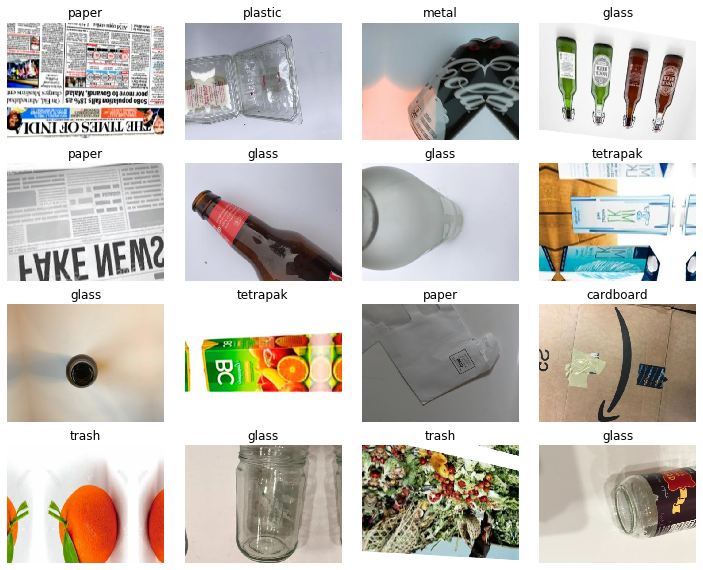

In [6]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [7]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate, callback_fns=ShowGraph)

### What is resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Finding a learning rate

I'm going to find a learning rate for gradient descent to make sure that my neural network converges reasonably quickly without missing the optimal error. For a refresher on the learning rate, check out Jeremy Jordan's [post](https://www.jeremyjordan.me/nn-learning-rate/) on choosing a learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.08E-03
Min loss divided by 10: 4.17E-03


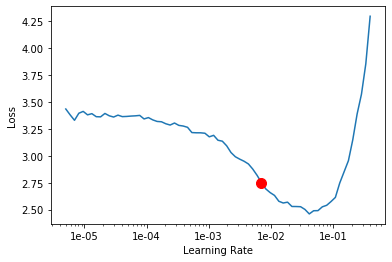

In [9]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

### Training

epoch,train_loss,valid_loss,accuracy,time
0,1.312082,0.553269,0.823394,00:43
1,0.906505,0.440355,0.858563,00:45
2,0.707158,0.406594,0.867737,00:44
3,0.661271,0.425713,0.870031,00:44
4,0.681096,0.386257,0.870795,00:44
5,0.591954,0.373938,0.885321,00:42
6,0.640078,0.399817,0.874618,00:43
7,0.649236,0.485601,0.853211,00:42
8,0.710507,0.557779,0.828746,00:44
9,0.797063,0.455997,0.849388,00:44


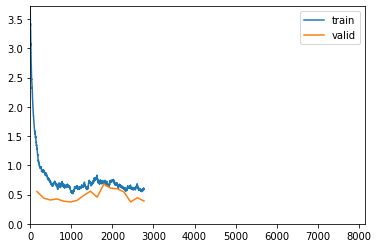

In [ ]:
learn.metrics=[accuracy]
learn.fit_one_cycle(50,max_lr=slice(4.17E-03,7.08E-03))

### Saving and loading Model

In [708]:
learn.save("resnet50_best")

In [133]:
learn = learn.load("resnet50_2")

### VIsualizing most incorrect images

In [134]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

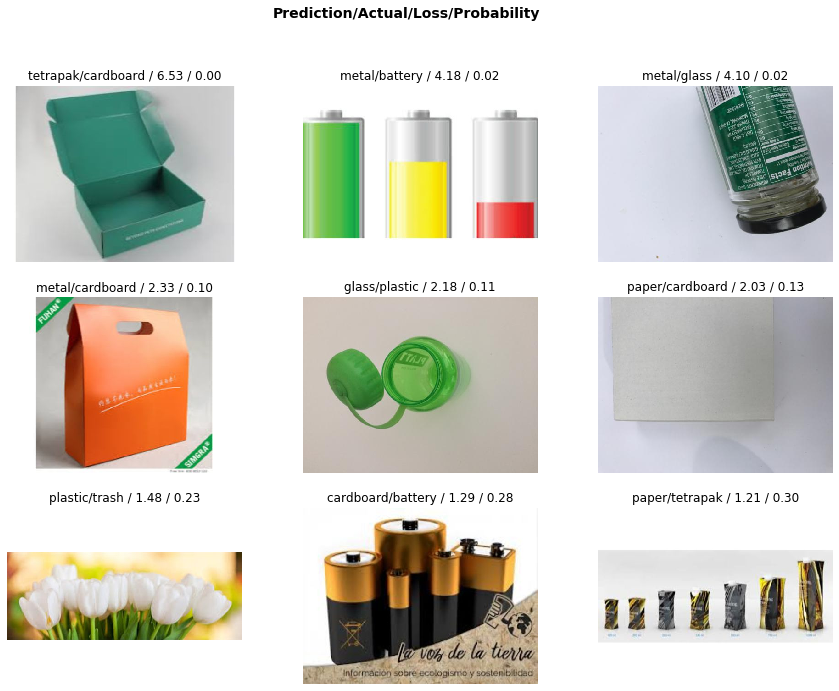

In [135]:
interp.plot_top_losses(9, figsize=(15,11))

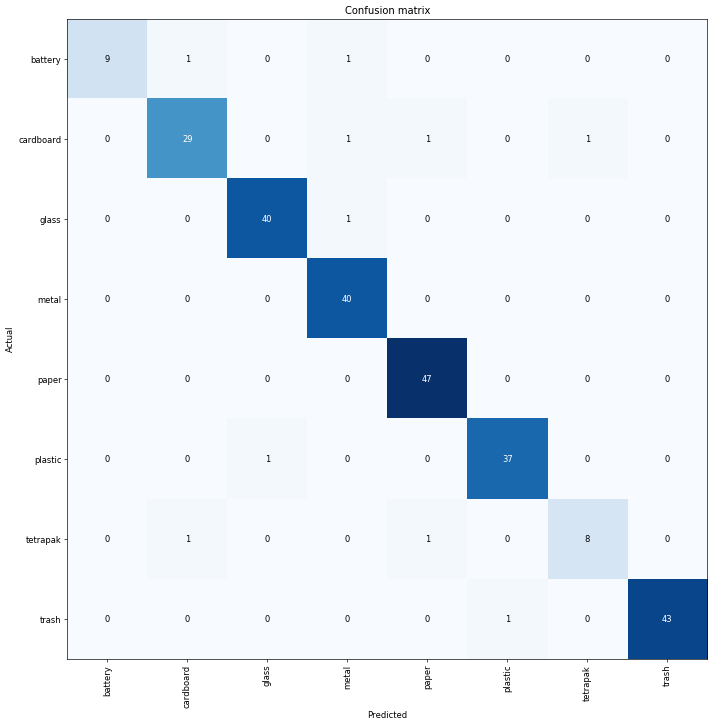

In [136]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [137]:
interp.most_confused(min_val=2)

[]

## Loading a single image and testing it with our model

In [153]:
img = open_image('new_test/test26.jpg')

In [154]:
img.data.shape
new_height = 512 * img.data.shape[1] / img.data.shape[2]

In [155]:
img.resize(torch.Size([img.shape[0],int(new_height),512]))
img.data.shape

torch.Size([3, 288, 512])

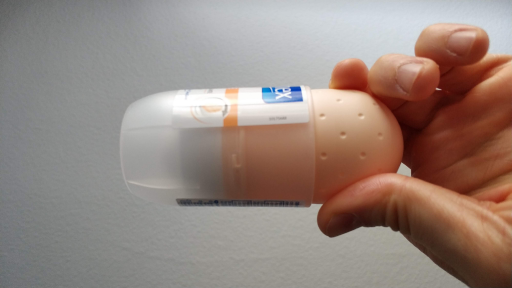

In [156]:
img

In [157]:
pred_class,pred_idx,outputthirds = learn.predict(img)
pred_class

Category plastic

## 4. Make new predictions on test data


In [709]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [710]:
print(preds[0].shape)
preds[0]

torch.Size([397, 8])


tensor([[3.6521e-07, 2.5545e-07, 2.1196e-03,  ..., 4.3925e-04, 1.8486e-05,
         9.8251e-06],
        [1.3376e-05, 2.6084e-08, 3.0500e-05,  ..., 1.1307e-05, 9.5464e-07,
         6.5503e-07],
        [2.4188e-10, 7.5931e-10, 1.0000e+00,  ..., 3.8838e-07, 3.2457e-09,
         4.7986e-07],
        ...,
        [2.8756e-10, 9.9996e-01, 6.8006e-08,  ..., 7.1126e-10, 1.0161e-09,
         6.3144e-07],
        [7.4424e-09, 2.8846e-07, 4.7390e-08,  ..., 2.5131e-03, 3.7726e-08,
         9.6552e-01],
        [8.4980e-08, 5.8210e-01, 1.1722e-03,  ..., 2.2252e-03, 2.3351e-03,
         1.9933e-05]])

These are the predicted probablities for each image.

In [711]:
data.classes

['battery',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'plastic',
 'tetrapak',
 'trash']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [712]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [713]:
pred_list = []
for max_idx in max_idxs:
    pred_list.append(data.classes[max_idx])

In [714]:
pred_list[27]

'cardboard'

These are the predicted labels of all the images! Let's check if the first image is actually glass.

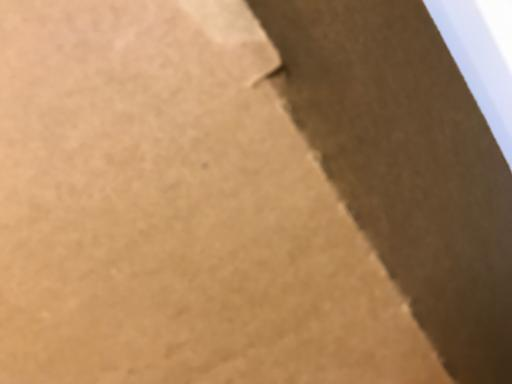

In [715]:
learn.data.test_ds[27][0]

It is!

Next, I'll get the actual labels from the test dataset.

In [716]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [717]:
## predicted values
print(pred_list[55:65])
## actual values
print(y[55:65])

['metal', 'plastic', 'trash', 'glass', 'paper', 'plastic', 'glass', 'trash', 'trash', 'trash']
['metal', 'plastic', 'trash', 'glass', 'paper', 'plastic', 'glass', 'trash', 'trash', 'trash']


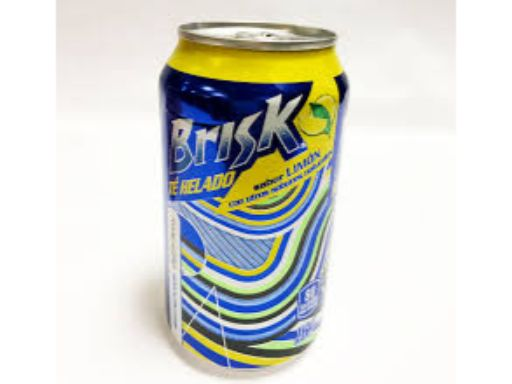

In [718]:
learn.data.test_ds[0][0]



### Test confusion matrix

In [719]:
cm = confusion_matrix(y,yhat)
print(cm)

[[13  0  1  4  0  0  0  0]
 [ 0 47  0  0  1  0  0  0]
 [ 0  0 59  2  0  1  0  0]
 [ 0  0  0 60  0  0  0  0]
 [ 0  1  0  0 70  0  0  0]
 [ 0  1  0  2  1 53  0  0]
 [ 0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0 66]]


Let's try and make this matrix a little prettier.

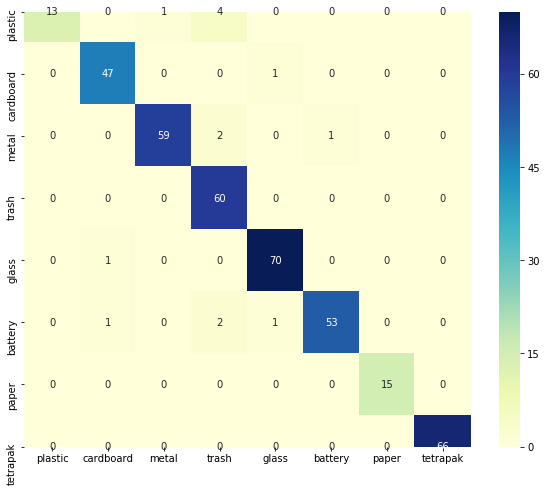

In [720]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

## Accuracy on test

In [721]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [722]:
accuracy = correct/sum(sum(cm))
accuracy

0.964735516372796